# 2D Isostatic gravity inversion - Inverse Problem

Este [IPython Notebook](http://ipython.org/videos.html#the-ipython-notebook) utiliza a biblioteca de código aberto [Fatiando a Terra](http://fatiando.org/)

In [1]:
%matplotlib inline
import numpy as np
from scipy.misc import derivative
import scipy as spy
from scipy import interpolate
import matplotlib
import matplotlib.pyplot as plt
import math
import cPickle as pickle
import datetime
#from IPython.display import Image as img
#from IPython.display import Markdown as md
#from IPython.display import display as dp
import string as st

from scipy.misc import imread

from __future__ import division

from fatiando import gravmag, mesher, utils, gridder
from fatiando.mesher import Prism, Polygon
from fatiando.gravmag import prism
from fatiando.utils import ang2vec, si2nt, contaminate
from fatiando.gridder import regular
from fatiando.vis import mpl

from numpy.testing import assert_almost_equal
from numpy.testing import assert_array_almost_equal
from pytest import raises

plt.rc('font', size=16)

/Users/macelabastos/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
import functions as fc

## Model parameters

In [3]:
# Model`s limits
ymin = 0.0
ymax = 383000.0
zmin = -1000.0
zmax = 45000.0
xmin = -100000.0
xmax = 100000.0

area = [ymin, ymax, zmax, zmin]

## Prisms coordenates.

In [4]:
ny = 150 # number of observation datas and number of prisms along the profile
# coordinates defining the horizontal boundaries of the
# adjacent columns along the profile
y = np.linspace(ymin, ymax, ny)

## Observation coordinates.

In [5]:
# coordinates of the center of the columns forming the
# interpretation model
n = ny - 1
dy = (ymax - ymin)/n
ycmin = ymin + 0.5*dy
ycmax = ymax - 0.5*dy
yc = np.reshape(np.linspace(ycmin, ycmax, n),(n,1))
x = np.zeros_like(yc)
z = np.zeros_like(yc)-150.0

In [6]:
## Edge extension (observation coordinates)
sigma = 2.0
edge = sigma*dy*n

## Model parameters

In [7]:
# Model densities
# Indices and polygons relationship:
# cc = continental crust layer
# oc = ocean crust layer
# w = water layer
# s = sediment layer
# m = mantle layer
dw = np.array([1030.0])
ds0 = np.array([2350.0])
ds1 = np.array([2850.0])
dcc = np.array([2870.0])
doc = np.array([2885.0])
dm = np.array([3230.0])
#dc = dcc
# coordinate defining the horizontal boundaries of the continent-ocean boundary
COT = 334000.0
# list defining crust density variance
dc = np.zeros_like(yc)
aux = yc <= COT
for i in range(len(yc[aux])):
    dc[i] = dcc
for i in range(len(yc[aux]),n):
    dc[i] = doc    
# defining sediments layers density matrix
ds = np.vstack((np.reshape(np.repeat(ds0,n),(1,n)),np.reshape(np.repeat(ds1,n),(1,n))))

# S0 => isostatic compensation surface (Airy's model)
S0 = np.array([41000.0])

## Surface water

In [8]:
bathymetry = np.reshape(np.loadtxt('../data/etopo1_pelotas.txt'),(n,1))
tw = 0.0 - bathymetry

## Interpreted model

In [9]:
toi = np.reshape(np.loadtxt('../data/pelotas_profile_interpreted_toi_surface.txt'),(n,1))

In [10]:
interpreted_basement = np.reshape(np.loadtxt('../data/pelotas_profile_interpreted_basement_surface.txt'),(n,1))

In [11]:
interpreted_moho = np.reshape(np.loadtxt('../data/pelotas_profile_interpreted_moho_surface.txt'),(n,1))

In [12]:
dS0 = np.array([2700.0])

In [13]:
# 1st layer sediments thickness
ts0 = toi - tw

In [14]:
# 2nd layer sediments thickness
ts1 = interpreted_basement - toi

In [15]:
# thickness sediments vector
ts = np.vstack((np.reshape(ts0,(1,n)),np.reshape(ts1,(1,n))))

In [16]:
# layer mantle thickness
tm = S0 - interpreted_moho

In [17]:
# pelotas profile parameters vector
p_interp = np.vstack((ts1, tm, dS0))

In [18]:
# observed data
gobs = np.reshape(np.loadtxt('../data/pelotas_profile_gz.txt'),(n,1))

## Known depths

In [19]:
# Known values: basement and moho surfaces

base_known = np.loadtxt('../data/pelotas_profile_basement_known_depths.txt')
#base_known = np.loadtxt('../data/pelotas_profile_basement_more_known_depths.txt')
#base_known_new = np.loadtxt('../data/pelotas_profile_basement_new_known_depths.txt')
#base_known_old = np.loadtxt('../data/pelotas_profile_basement_known_depths.txt')

moho_known = np.loadtxt('../data/pelotas_profile_moho_known_depths.txt')

## Interpretive model

In [20]:
# initial guess basement surface
ini_basement = np.reshape(np.loadtxt('../data/pelotas_profile_initial_basement_surface.txt'),(n,1))

# initial guess moho surface
ini_moho = np.reshape(np.loadtxt('../data/pelotas_profile_initial_moho_surface.txt'),(n,1))

# initial guess data
g0 = np.reshape(np.loadtxt('../data/pelotas_profile_initial_guess_gravity_data.txt'),(n,1))

# Synthetic data

## Inversion model

In [21]:
g = np.reshape(np.loadtxt('../data/pelotas_profile_predicted_gravity_data_-12_-8_-5_-5_field_data.txt'),(n,1))
p = np.reshape(np.loadtxt('../data/pelotas_profile_parameter_vector_-12_-8_-5_-5_field_data.txt'),(2*n+1,1))

In [22]:
# Inverrsion results
RM = S0 + p[n+n]
basement = tw + ts0 + p[0:n]
moho = S0 - p[n:n+n]

## Lithostatic Stress

In [23]:
sgm_interp = 9.81*(10**(-6))*(dw*tw + ds0*ts0 + ds1*ts1 + dc*(S0-tw-ts0-ts1-tm)+dm*tm)

sgm = 9.81*(10**(-6))*(dw*tw + ds0*ts0 + ds1*p[0:n] + dc*(S0-tw-ts0-p[0:n]-p[n:n+n])+dm*p[n:n+n])

## Inversion model plot

In [24]:
polygons_water = []
for (yi, twi) in zip(yc, tw):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_water.append(Polygon(np.array([[y1, y2, y2, y1], 
                                            [0.0, 0.0, twi, twi]]).T,
                                               props={'density': dw - dcc}))
polygons_sediments0 = []
for (yi, twi, s0i) in zip(yc, np.reshape(tw,(n,)), np.reshape(toi,(n,))):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_sediments0.append(Polygon(np.array([[y1, y2, y2, y1], 
                                                [twi, twi, s0i, s0i]]).T,
                                                    props={'density': ds0 - dcc}))
    
polygons_sediments1 = []
for (yi, s0i, s1i) in zip(yc, np.reshape(toi,(n,)), np.reshape(basement,(n,))):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_sediments1.append(Polygon(np.array([[y1, y2, y2, y1], 
                                                [s0i, s0i, s1i, s1i]]).T,
                                                   props={'density': ds1 - dcc}))
    
polygons_crust = []
for (yi, si, Si, dci) in zip(yc, np.reshape(basement,(n,)), np.reshape(moho,(n,)), dc):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_crust.append(Polygon(np.array([[y1, y2, y2, y1], 
                                            [si, si, Si, Si]]).T,
                                                props={'density': dci - dcc})) 

polygons_mantle = []
for (yi, Si) in zip(yc, np.reshape(moho,(n,))):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_mantle.append(Polygon(np.array([[y1, y2, y2, y1], 
                                                [Si, Si, 50000., 50000.]]).T,
                                                    props={'density': dm - dcc}))

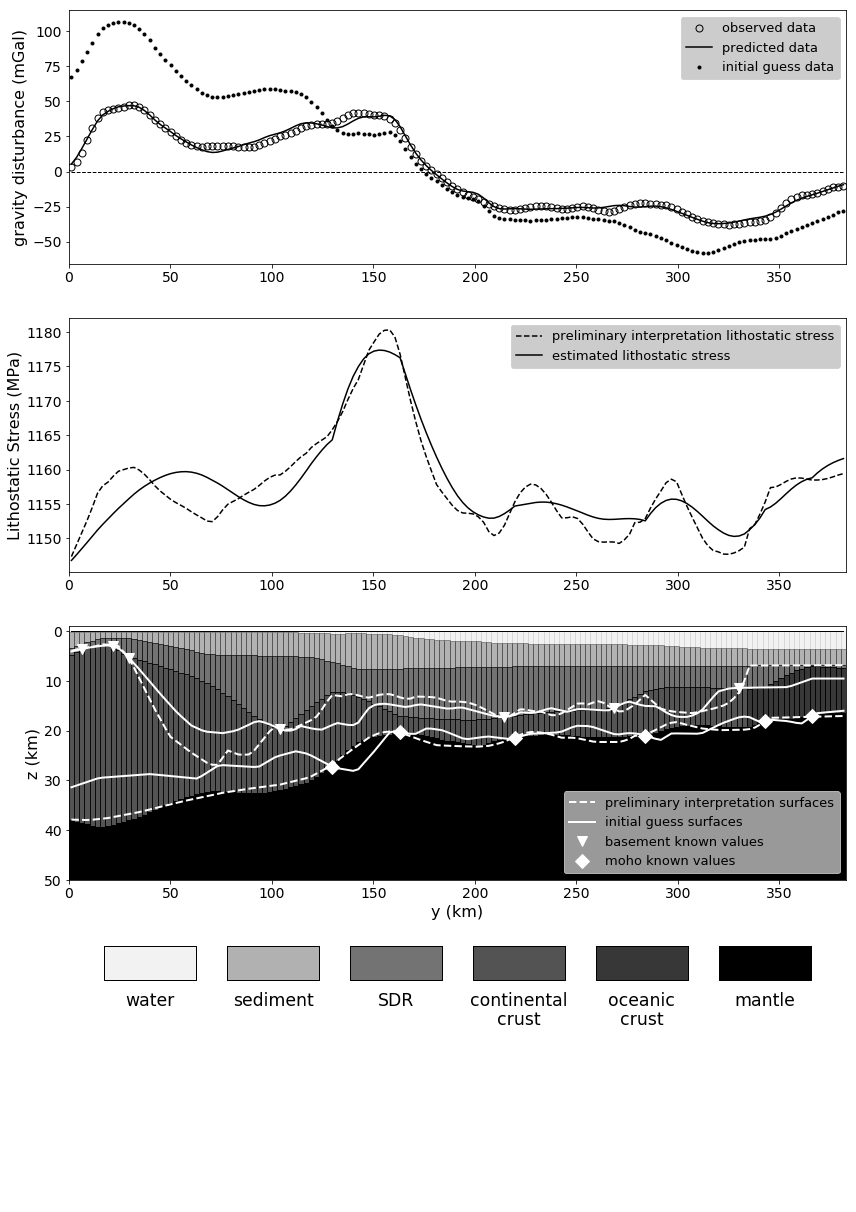

In [25]:
%matplotlib inline
plt.close('all')
fig = plt.figure(figsize=(12,17))
#alfa = 3.33*(17)/(12)
#fig = plt.figure(figsize=(3.33,alfa), dpi=600)

plt.subplot(4,1,1)
zeros = np.zeros_like(yc)
plt.plot(0.001*yc, zeros, '--k', linewidth=1)
plt.plot(0.001*yc, gobs, 'ok', mfc='none', markersize=7, label='observed data')
plt.plot(0.001*yc, g, '-k', label='predicted data')
plt.plot(0.001*yc, g0, '.k', label='initial guess data')
plt.xlim(0.001*ymin, 0.001*ymax)
plt.ylabel('gravity disturbance (mGal)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.tight_layout()
plt.legend(loc='best', fontsize=13, facecolor='silver')

plt.subplot(4,1,2)
plt.plot(0.001*yc, sgm_interp, '--k', label='preliminary interpretation lithostatic stress')
plt.plot(0.001*yc, sgm, '-k', label='estimated lithostatic stress')
plt.xlim(0.001*ymin, 0.001*ymax)
plt.ylabel('Lithostatic Stress (MPa)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.tight_layout()
plt.legend(loc='best', fontsize=13, facecolor='silver')        

plt.subplot(4,1,3)
plt.plot(yc, zeros, '-k', linewidth=1)
#mpl.paths([[ymin, 0.0]], [[ymax, 0.0]], style='-k', linewidth=1)
aux = yc <= COT

for (pwi) in (polygons_water):
    mpl.polygon(pwi, style='None', linewidth=0, fill='black', alpha=0.05)
for (ps0i) in (polygons_sediments0):
    mpl.polygon(ps0i, style='None', linewidth=0, fill='black', alpha=0.3)
for (ps1i) in (polygons_sediments1):
    mpl.polygon(ps1i, style='None', linewidth=0, fill='black', alpha=0.55)
for (pci) in (polygons_crust[:len(yc[aux])]):
    mpl.polygon(pci, style='None', linewidth=0, fill='black', alpha=0.67)
for (pcoi) in (polygons_crust[len(yc[aux]):n]):
    mpl.polygon(pcoi, style='None', linewidth=0, fill='black', alpha=0.78)
for (pmi) in (polygons_mantle):
    mpl.polygon(pmi, style='None', linewidth=0, fill='black')

plt.plot(yc, interpreted_basement, '--w', linewidth=2, label='preliminary interpretation surfaces')
plt.plot(yc, interpreted_moho, '--w', linewidth=2)
plt.plot(yc, ini_basement, '-w', linewidth=2, label='initial guess surfaces')
plt.plot(yc, ini_moho, '-w', linewidth=2)
plt.plot(base_known[:,0], base_known[:,1], 'vw', markersize=9.5, label='basement known values')
plt.plot(moho_known[:,0], moho_known[:,1], 'Dw', markersize=9.5, label='moho known values')
plt.ylim(50000., zmin)
plt.xlim(ymin, ymax)
plt.xlabel('y (km)', fontsize=16)
plt.ylabel('z (km)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
mpl.m2km()
#plt.tight_layout()
plt.legend(loc='lower right', fontsize=13, facecolor='silver')

plt.subplot(4,1,4)#, frame_on=False)
X, Y = fig.get_dpi()*fig.get_size_inches()
plt.axis('off')

layers_list1 = ['water', 'sediment', 'SDR', 'continental', 'oceanic', 'mantle']
layers_list2 = ['', '', '', 'crust', 'crust', '']
alpha_list = [0.05, 0.3, 0.55, 0.67, 0.78, 1.0]
ncols = len(alpha_list)
nrows = 1
h = Y / nrows
w = X / (ncols + 1)

i=ncols-1
for alpha, layers1, layers2 in zip(alpha_list, layers_list1, layers_list2):
    col = i // nrows
    row = i % nrows
    x = X - (col*w) - w
    
    yi_line = Y
    yf_line1 = Y - Y*0.15
    yf_line2 = Y - Y*0.30
    yf_line3 = Y - Y*0.45
    yf_line4 = Y - Y*0.60
    yf_line5 = Y - Y*0.75
    yf_line6 = Y - Y*0.90
    yf_line7 = Y - Y*1.0
    yi_text1 = Y - Y*0.2
    yi_text2 = Y - Y*0.28
    
    plt.text(x+w*0.375, yi_text1, layers1, fontsize=(w*0.14), horizontalalignment='center', verticalalignment='top')
    plt.text(x+w*0.375, yi_text2, layers2, fontsize=(w*0.14), horizontalalignment='center', verticalalignment='top')
    i-=1
    poly1 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yi_line, yi_line, yf_line1, yf_line1]]).T)
    poly2 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yf_line1, yf_line1, yf_line2, yf_line2]]).T)
    poly3 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yf_line2, yf_line2, yf_line3, yf_line3]]).T)
    poly4 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yf_line3, yf_line3, yf_line4, yf_line4]]).T)
    poly5 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yf_line4, yf_line4, yf_line5, yf_line5]]).T)
    poly6 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yf_line5, yf_line5, yf_line6, yf_line6]]).T)
    poly7 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yf_line6, yf_line6, yf_line7, yf_line7]]).T)
    mpl.polygon(poly1, style='None', linewidth=1, fill='black', alpha=alpha)
    mpl.polygon(poly2, style='None', linewidth=0, fill='white', alpha=alpha)
    mpl.polygon(poly3, style='None', linewidth=0, fill='white', alpha=alpha)
    mpl.polygon(poly4, style='None', linewidth=0, fill='white', alpha=alpha)
    mpl.polygon(poly5, style='None', linewidth=0, fill='white', alpha=alpha)
    mpl.polygon(poly6, style='None', linewidth=0, fill='white', alpha=alpha)
    mpl.polygon(poly7, style='None', linewidth=0, fill='white', alpha=alpha)
    
plt.tight_layout()

#mpl.savefig('../manuscript/figures/pelotas-profile-observed-data.png', dpi='figure')
#mpl.savefig('../manuscript/figures/pelotas-profile-observed-data-no-vinc-isostatic.png', dpi='figure')
plt.show()      

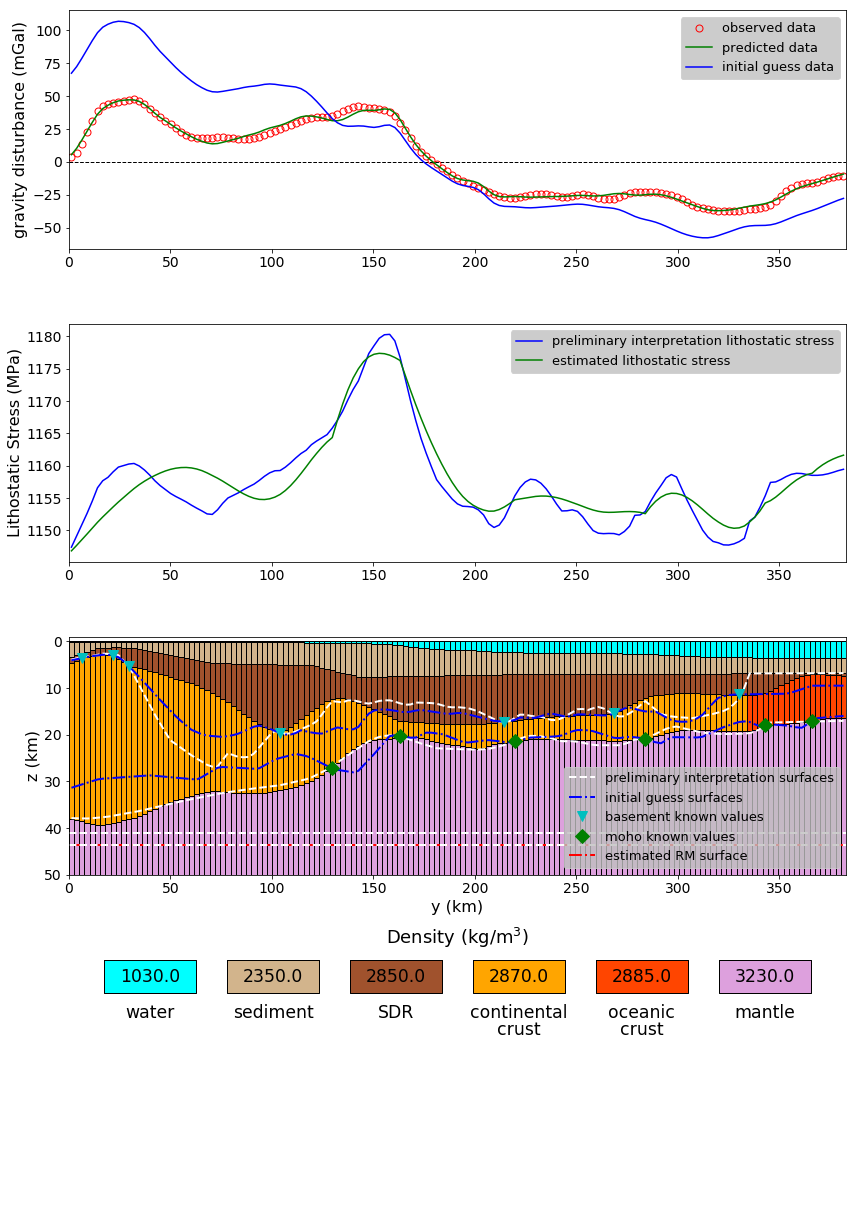

In [27]:
%matplotlib inline
plt.close('all')
fig = plt.figure(figsize=(12,17))

plt.subplot(4,1,1)
#plt.title('Gravity disturbance', fontsize=18)
mpl.paths([[ymin, 0.]], [[ymax, 0.]], style='--k', linewidth=1)
plt.plot(0.001*yc, gobs, 'or', mfc='none', markersize=7, label='observed data')
plt.plot(0.001*yc, g, '-g', label='predicted data')
plt.plot(0.001*yc, g0, '-b', label='initial guess data')
#plt.ylim(-5.,70.)
plt.xlim(0.001*ymin, 0.001*ymax)
plt.ylabel('gravity disturbance (mGal)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=13, facecolor='silver')

plt.subplot(4,1,2)
mpl.plot(0.001*yc, sgm_interp, '-b', label='preliminary interpretation lithostatic stress')
mpl.plot(0.001*yc, sgm, '-g', label='estimated lithostatic stress')
plt.xlim(0.001*ymin, 0.001*ymax)
#plt.ylabel('Normalized Lithostatic Stress', fontsize=16)
plt.ylabel('Lithostatic Stress (MPa)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=13, facecolor='silver')

plt.subplot(4,1,3)
#plt.title('Sedimentary basin', fontsize=18)

mpl.paths([[ymin, 0.0]], [[ymax, 0.0]], style='-k', linewidth=1)
aux = yc <= COT
for (pwi) in (polygons_water):
    mpl.polygon(pwi, style='-k', linewidth=1, fill='aqua')
for (ps0i) in (polygons_sediments0):
    mpl.polygon(ps0i, style='-k', linewidth=1, fill='tan')
for (ps1i) in (polygons_sediments1):
    mpl.polygon(ps1i, style='-k', linewidth=1, fill='sienna')
for (pci) in (polygons_crust[:len(yc[aux])]):
    mpl.polygon(pci, style='-k', linewidth=1, fill='orange')
for (pcoi) in (polygons_crust[len(yc[aux]):n]):
    mpl.polygon(pcoi, style='-k', linewidth=1, fill='orangered')
for (pmi) in (polygons_mantle):
    mpl.polygon(pmi, style='-k', linewidth=1, fill='plum')

plt.plot(yc, interpreted_basement, '--w', linewidth=2, label='preliminary interpretation surfaces')
plt.plot(yc, interpreted_moho, '--w', linewidth=2)
plt.plot(yc, ini_basement, '-.b', linewidth=2, label='initial guess surfaces')
plt.plot(yc, ini_moho, '-.b', linewidth=2)
plt.plot(base_known[:,0], base_known[:,1], 'vc', markersize=9.5, label='basement known values')
#plt.plot(base_known_new[:,0], base_known_new[:,1], 'vb', markersize=9.5, label='new basement known values')
#plt.plot(base_known_old[:,0], base_known_old[:,1], 'Dc', markersize=9.5, label='basement known values')
plt.plot(moho_known[:,0], moho_known[:,1], 'Dg', markersize=9.5, label='moho known values')
#plt.plot(moho_known_new[:,0], moho_known_new[:,1], 'vb', markersize=9.5, label='new moho known values')
#plt.plot(moho_known_old[:,0], moho_known_old[:,1], 'Dg', markersize=9.5, label='moho known values')
mpl.paths([[ymin, S0+p[n+n]]], [[ymax, S0+p[n+n]]], style='-.r', linewidth=2, label='estimated RM surface')
mpl.paths([[ymin, S0]], [[ymax, S0]], style='--w', linewidth=2)
mpl.paths([[ymin, S0+dS0]], [[ymax, S0+dS0]], style='--w', linewidth=2)
plt.ylim(50000., zmin)
plt.xlim(ymin, ymax)
plt.xlabel('y (km)', fontsize=16)
plt.ylabel('z (km)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
mpl.m2km()
plt.legend(loc='lower right', fontsize='13', facecolor='silver')

plt.subplot(4,1,4)
X, Y = fig.get_dpi()*fig.get_size_inches()
plt.title('Density (kg/m$^{3}$)', fontsize=18)
plt.axis('off')

layers_list1 = ['water', 'sediment', 'SDR', 'continental', 'oceanic', 'mantle']
layers_list2 = ['', '', '', 'crust', 'crust', '']
colors_list = ['aqua', 'tan', 'sienna', 'orange', 'orangered', 'plum']
density_list = ['1030.0', '2350.0', '2850.0', '2870.0', '2885.0', '3230.0']
ncols = len(colors_list)
nrows = 1
h = Y / nrows
w = X / (ncols + 1)

i=ncols-1
for color, density, layers1, layers2 in zip(colors_list, density_list, layers_list1, layers_list2):
    col = i // nrows
    row = i % nrows
    x = X - (col*w) - w
    
    yi_line = Y
    yf_line1 = Y - Y*0.15
    yf_line2 = Y - Y*0.30
    yf_line3 = Y - Y*0.45
    yf_line4 = Y - Y*0.60
    yf_line5 = Y - Y*0.75
    yf_line6 = Y - Y*0.90
    yf_line7 = Y - Y*1.0
    yi_text1 = Y - Y*0.2
    yi_text2 = Y - Y*0.28
    yi_text3 = Y - Y*0.075
    
    plt.text(x+w*0.375, yi_text1, layers1, fontsize=(w*0.14), horizontalalignment='center', verticalalignment='top')
    plt.text(x+w*0.375, yi_text2, layers2, fontsize=(w*0.14), horizontalalignment='center', verticalalignment='top')
    plt.text(x+w*0.375, yi_text3, density, fontsize=(w*0.14), horizontalalignment='center', verticalalignment='center')
    i-=1
    poly1 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yi_line, yi_line, yf_line1, yf_line1]]).T)
    poly2 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yf_line1, yf_line1, yf_line2, yf_line2]]).T)
    poly3 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yf_line2, yf_line2, yf_line3, yf_line3]]).T)
    poly4 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yf_line3, yf_line3, yf_line4, yf_line4]]).T)
    poly5 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yf_line4, yf_line4, yf_line5, yf_line5]]).T)
    poly6 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yf_line5, yf_line5, yf_line6, yf_line6]]).T)
    poly7 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yf_line6, yf_line6, yf_line7, yf_line7]]).T)
    mpl.polygon(poly1, style='None', linewidth=1, fill=color)
    mpl.polygon(poly2, style='None', linewidth=0, fill='white')
    mpl.polygon(poly3, style='None', linewidth=0, fill='white')
    mpl.polygon(poly4, style='None', linewidth=0, fill='white')
    mpl.polygon(poly5, style='None', linewidth=0, fill='white')
    mpl.polygon(poly6, style='None', linewidth=0, fill='white')
    mpl.polygon(poly7, style='None', linewidth=0, fill='white')
    
plt.tight_layout()

#mpl.savefig('../manuscript/figures/pelotas-profile-observed-data-colors.png', dpi='figure')
plt.show()